In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree 
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from xgboost import XGBClassifier

In [2]:
df = pd.read_csv('loan3000.csv')
df.head()

,Unnamed: 0,outcome,purpose_,dti,borrower_score,payment_inc_ratio
0,32109,paid off,debt_consolidation,21.23,0.40,5.11135
1,16982,default,credit_card,15.49,0.40,5.43165
2,25335,paid off,debt_consolidation,27.30,0.70,9.23003
3,34580,paid off,major_purchase,21.11,0.40,2.33482
4,14424,default,debt_consolidation,16.46,0.45,12.10320


In [3]:
df.purpose_.value_counts()

debt_consolidation    1738
credit_card            525
other                  318
home_improvement       186
major_purchase         115
small_business          88
medical                 30
Name: purpose_, dtype: int64

In [4]:
y = df.outcome.replace(to_replace=['paid off','default'],value=[0,1])
X = pd.get_dummies(df.drop(['outcome','Unnamed: 0'],axis=1), drop_first=True)
X_train, X_test, y_train,y_test =train_test_split(X,y,test_size=0.2)

### Logistic Regression

Predicted    0    1
Actual             
0          202  121
1          102  175
accuracy score : 0.6283333333333333 
AUC score : 0.6278449502133713


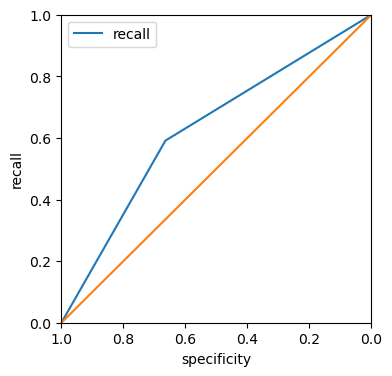

In [5]:
logReg_model = LogisticRegression(penalty = 'l2', solver='liblinear')
logReg_model.fit(X_train,y_train)
y_hat_log = logReg_model.predict(X_test)
conf_log = pd.crosstab(y_hat_log,y_test,rownames=['Actual'],colnames=['Predicted'])
print(conf_log)
print("accuracy score : {} ".format(accuracy_score(y_test,y_hat_log)))
fpr, tpr, thresholds = roc_curve(y_test,y_hat_log)
roc_df = pd.DataFrame({'recall':tpr , 'specificity': 1-fpr})
ax= roc_df.plot(x='specificity',y='recall',figsize=(4,4))
ax.set_ylim(0,1)
ax.set_xlim(1,0)
ax.plot((1,0),(0,1))
ax.set_xlabel('specificity')
ax.set_ylabel('recall')
print("AUC score : {}".format(roc_auc_score(y_test,y_hat_log)))

### K-Nearest Neighbors without PCA

In [6]:
knn = KNeighborsClassifier()
knn.fit(X_train,y_train)
param_grid = {  'n_neighbors' : range(3,20) }
rfcv = GridSearchCV(estimator=knn, param_grid=param_grid, cv = 5)
rfcv.fit(X_train,y_train)
n_neighbors = rfcv.best_params_
n_neighbors

{'n_neighbors': 19}

Predicted    0    1
Actual             
0          194  156
1          110  140
accuracy score : 0.5566666666666666 
AUC score : 0.5555654338549075


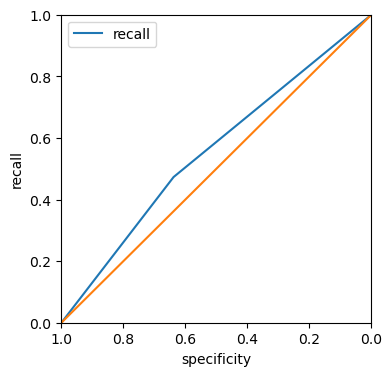

In [7]:
knn = KNeighborsClassifier(n_neighbors=19)
knn.fit(X_train,y_train)
y_hat_knn=knn.predict(X_test)
conf_log = pd.crosstab(y_hat_knn,y_test,rownames=['Actual'],colnames=['Predicted'])
print(conf_log)
print("accuracy score : {} ".format(accuracy_score(y_test,y_hat_knn)))
fpr, tpr, thresholds = roc_curve(y_test,y_hat_knn)
roc_df = pd.DataFrame({'recall':tpr , 'specificity': 1-fpr})
ax= roc_df.plot(x='specificity',y='recall',figsize=(4,4))
ax.set_ylim(0,1)
ax.set_xlim(1,0)
ax.plot((1,0),(0,1))
ax.set_xlabel('specificity')
ax.set_ylabel('recall')
print("AUC score : {}".format(roc_auc_score(y_test,y_hat_knn)))

### Principal Components Analysis

In [8]:
X

,dti,borrower_score,payment_inc_ratio,purpose__debt_consolidation,purpose__home_improvement,purpose__major_purchase,purpose__medical,purpose__other,purpose__small_business
0,21.23,0.40,5.11135,1,0,0,0,0,0
1,15.49,0.40,5.43165,0,0,0,0,0,0
2,27.30,0.70,9.23003,1,0,0,0,0,0
3,21.11,0.40,2.33482,0,0,1,0,0,0
4,16.46,0.45,12.10320,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
2995,13.30,0.50,18.36620,1,0,0,0,0,0
2996,6.09,0.60,1.80421,0,0,0,0,1,0
2997,16.13,0.20,15.42180,1,0,0,0,0,0
2998,18.39,0.45,8.92335,1,0,0,0,0,0


In [9]:
y = df.outcome.replace(to_replace=['paid off','default'],value=[0,1])
X = pd.get_dummies(df.drop(['outcome','Unnamed: 0','purpose_'],axis=1), drop_first=True)
pcs = PCA(n_components=3)
pcs.fit(X)
PCS = pd.DataFrame(pcs.components_,columns = X.columns)
X['C0']=PCS.iloc[0,0]*X['dti']+PCS.iloc[0,1]*X.borrower_score +PCS.iloc[0,2]*X.payment_inc_ratio
X['C1']=PCS.iloc[1,0]*X['dti']+PCS.iloc[1,1]*X.borrower_score +PCS.iloc[1,2]*X.payment_inc_ratio
X['C2']=PCS.iloc[2,0]*X['dti']+PCS.iloc[2,1]*X.borrower_score +PCS.iloc[2,2]*X.payment_inc_ratio


### Logistic Regression with PCA

Predicted    0    1
Actual             
0          215  124
1           98  163
accuracy score : 0.63 
AUC score : 0.6274226046687669


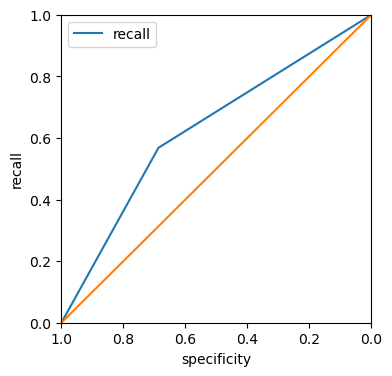

In [10]:
X = X[['C0','C1','C2']]
X_train, X_test, y_train,y_test =train_test_split(X,y,test_size=0.2)
logReg_model = LogisticRegression(penalty = 'l2', solver='liblinear')
logReg_model.fit(X_train,y_train)
y_hat_log = logReg_model.predict(X_test)
conf_log = pd.crosstab(y_hat_log,y_test,rownames=['Actual'],colnames=['Predicted'])
print(conf_log)
print("accuracy score : {} ".format(accuracy_score(y_test,y_hat_log)))
fpr, tpr, thresholds = roc_curve(y_test,y_hat_log)
roc_df = pd.DataFrame({'recall':tpr , 'specificity': 1-fpr})
ax= roc_df.plot(x='specificity',y='recall',figsize=(4,4))
ax.set_ylim(0,1)
ax.set_xlim(1,0)
ax.plot((1,0),(0,1))
ax.set_xlabel('specificity')
ax.set_ylabel('recall')
print("AUC score : {}".format(roc_auc_score(y_test,y_hat_log)))

### K-Nearest Neighbors with PCA

In [11]:


knn = KNeighborsClassifier()
knn.fit(X_train,y_train)
param_grid = {  'n_neighbors' : range(3,20) }
rfcv = GridSearchCV(estimator=knn, param_grid=param_grid, cv = 5)
rfcv.fit(X_train,y_train)
rfcv.best_params_

{'n_neighbors': 12}

Predicted    0    1
Actual             
0          172  133
1          141  154
accuracy score : 0.5433333333333333 
AUC score : 0.5430530663134108


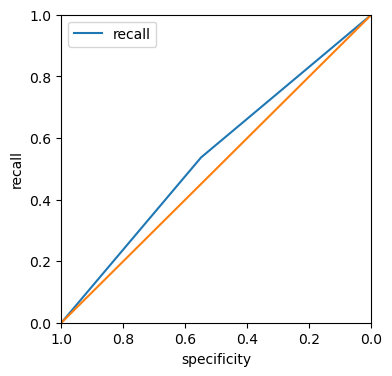

In [12]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train,y_train)
y_hat_knn=knn.predict(X_test)
conf_log = pd.crosstab(y_hat_knn,y_test,rownames=['Actual'],colnames=['Predicted'])
print(conf_log)
print("accuracy score : {} ".format(accuracy_score(y_test,y_hat_knn)))
fpr, tpr, thresholds = roc_curve(y_test,y_hat_knn)
roc_df = pd.DataFrame({'recall':tpr , 'specificity': 1-fpr})
ax= roc_df.plot(x='specificity',y='recall',figsize=(4,4))
ax.set_ylim(0,1)
ax.set_xlim(1,0)
ax.plot((1,0),(0,1))
ax.set_xlabel('specificity')
ax.set_ylabel('recall')
print("AUC score : {}".format(roc_auc_score(y_test,y_hat_knn)))

### KNN first phase modeling

In [13]:
y = df.outcome.replace(to_replace=['paid off','default'],value=[0,1])
X = pd.get_dummies(df.drop(['outcome','Unnamed: 0'],axis=1), drop_first=True)
knn = KNeighborsClassifier()
knn.fit(X,y)
param_grid = {  'n_neighbors' : range(3,20) }
rfcv = GridSearchCV(estimator=knn, param_grid=param_grid, cv = 5)
rfcv.fit(X,y)
n_neighbor = rfcv.best_params_
n_neighbor['n_neighbors']

13

In [14]:
knn = KNeighborsClassifier(n_neighbors= n_neighbor['n_neighbors'])
knn.fit(X,y)
Class = knn.predict_proba(X)[:,1]
X['knn'] = Class
X['knn']

0       0.307692
1       0.230769
2       0.461538
3       0.692308
4       0.692308
          ...   
2995    0.692308
2996    0.461538
2997    0.461538
2998    0.769231
2999    0.615385
Name: knn, Length: 3000, dtype: float64

### Second Phase: Tree model

In [15]:
X_train, X_test, y_train,y_test =train_test_split(X,y,test_size=0.2)

[Text(0.6071428571428571, 0.9166666666666666, 'X[9] <= 0.5\nentropy = 0.999\nsamples = 2400\nvalue = [1242, 1158]'),
 Text(0.35714285714285715, 0.75, 'X[1] <= 0.625\nentropy = 0.944\nsamples = 1368\nvalue = [874, 494]'),
 Text(0.21428571428571427, 0.5833333333333334, 'X[1] <= 0.375\nentropy = 0.978\nsamples = 1088\nvalue = [639, 449]'),
 Text(0.14285714285714285, 0.4166666666666667, 'entropy = 0.971\nsamples = 160\nvalue = [64, 96]'),
 Text(0.2857142857142857, 0.4166666666666667, 'X[9] <= 0.269\nentropy = 0.958\nsamples = 928\nvalue = [575, 353]'),
 Text(0.14285714285714285, 0.25, 'X[0] <= 17.15\nentropy = 0.828\nsamples = 207\nvalue = [153, 54]'),
 Text(0.07142857142857142, 0.08333333333333333, 'entropy = 0.879\nsamples = 178\nvalue = [125, 53]'),
 Text(0.21428571428571427, 0.08333333333333333, 'entropy = 0.216\nsamples = 29\nvalue = [28, 1]'),
 Text(0.42857142857142855, 0.25, 'X[2] <= 14.296\nentropy = 0.979\nsamples = 721\nvalue = [422, 299]'),
 Text(0.35714285714285715, 0.083333333

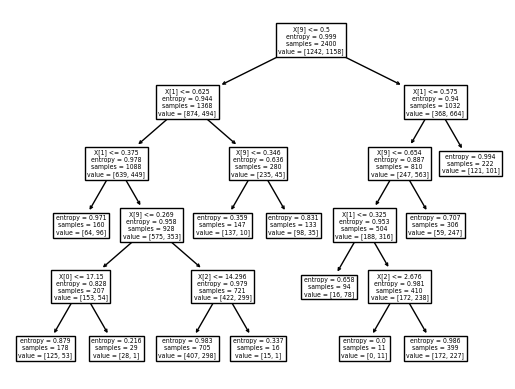

In [16]:
tree_model = DecisionTreeClassifier(random_state=1, criterion='entropy', min_impurity_decrease=0.003)
tree_model.fit(X_train,y_train)
plot_tree(tree_model)

In [17]:
y_hat_tree = tree_model.predict(X_test)
accuracy_score(y_test,y_hat_tree)

0.6616666666666666

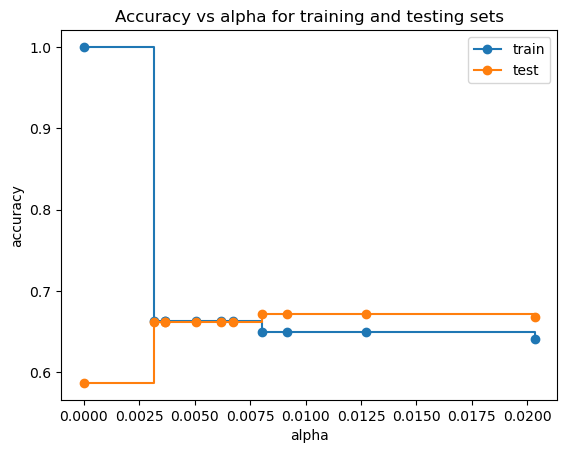

In [18]:
path = tree_model.cost_complexity_pruning_path(X_train,y_train)
alpha = path.ccp_alphas
clfs = []
for ccp_alpha in alpha:
    clf = DecisionTreeClassifier(random_state=1, ccp_alpha=ccp_alpha, criterion="entropy",min_impurity_decrease=0.0003)
    clf.fit(X_train, y_train)
    clfs.append(clf)
clfs = clfs[:-1]
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(alpha[:-1], train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(alpha[:-1], test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

### Second Phase: Random Forest

In [19]:
#rf = RandomForestClassifier(n_estimators=500, oob_score=True)
#rf.fit(X_train,y_train)
n = list(range(20,510,5))
oobscores =[]
for i in n:
    rf = RandomForestClassifier(n_estimators=i, criterion="entropy",oob_score=True)
    rf.fit(X_train,y_train)
    oobscores.append(rf.oob_score_)


<AxesSubplot:xlabel='n_estim'>

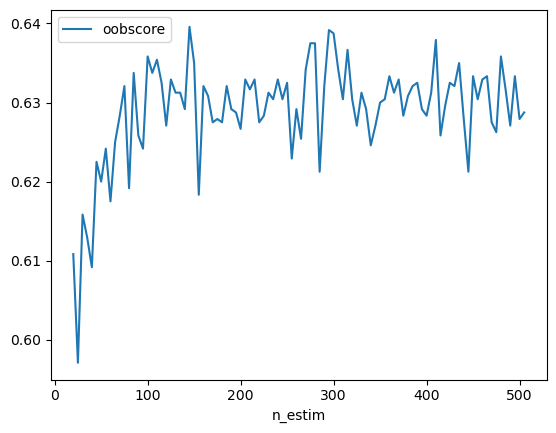

In [20]:
data = pd.DataFrame({'n_estim':n,'oobscore':oobscores})
data.plot(x='n_estim',y='oobscore')

In [21]:
rf = RandomForestClassifier(n_estimators=500,criterion="entropy")
rf.fit(X_train,y_train)
y_hat_rf=rf.predict(X_test)
accuracy_score(y_test,y_hat_rf)

0.6383333333333333

In [22]:
rf1 = RandomForestClassifier(n_estimators=500,criterion="gini",min_impurity_decrease=0.0008)
scores = cross_val_score(rf1,X,y,cv=10)
scores.mean()

0.6619999999999999

In [23]:
pd.DataFrame(confusion_matrix(y_test,y_hat_rf),index=['Paid off','Default'],columns=['Paid off','Default'])

,Paid off,Default
Paid off,218,95
Default,122,165


### Second Phase with XGBoost

In [24]:
xgb = XGBClassifier(objective='binary:logistic', n_estimators=500, learning_rate=0.01, subsample=0.63)
xgb.fit(X_train,y_train)
y_hat_xgb = xgb.predict(X_test)
accuracy_score(y_test,y_hat_xgb)


0.6716666666666666

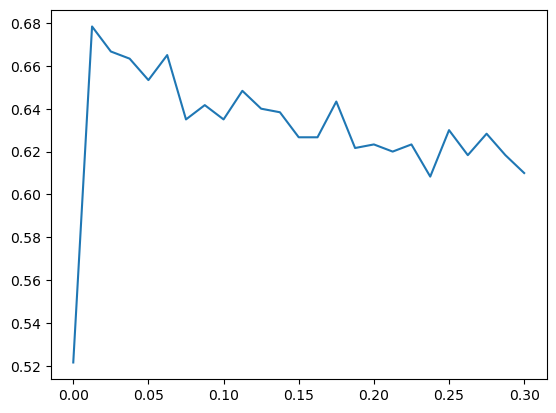

In [25]:
L = np.linspace(0,0.3,25)
scores=[]
for n in L:
    xgb = XGBClassifier(objective='binary:logistic', n_estimators=250, learning_rate=n, subsample=0.63)
    xgb.fit(X_train,y_train)
    y_hat_xgb = xgb.predict(X_test)
    scores.append(accuracy_score(y_test,y_hat_xgb))
plt.plot(list(L),scores)

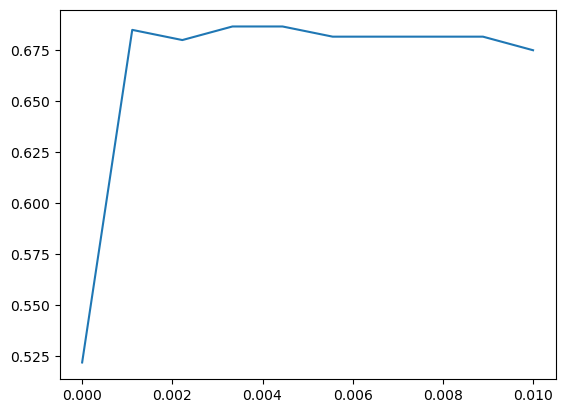

In [26]:
L = np.linspace(0,0.01,10)
scores=[]
for n in L:
    xgb = XGBClassifier(objective='binary:logistic', n_estimators=250, learning_rate=n, subsample=0.63)
    xgb.fit(X_train,y_train)
    y_hat_xgb = xgb.predict(X_test)
    scores.append(accuracy_score(y_test,y_hat_xgb))
plt.plot(list(L),scores)

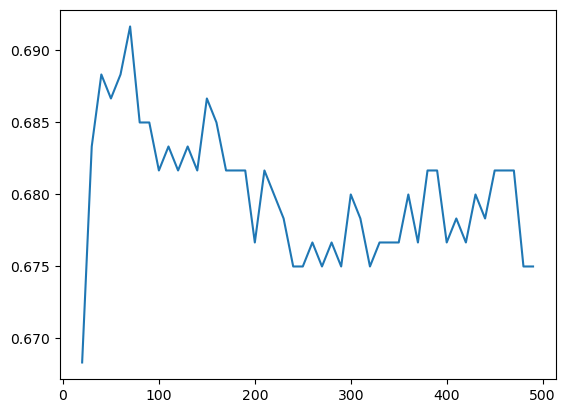

In [27]:
L = range(20,500,10)
scores=[]
for n in L:
    xgb = XGBClassifier(objective='binary:logistic', n_estimators=n, learning_rate=0.01, subsample=0.63)
    xgb.fit(X_train,y_train)
    y_hat_xgb = xgb.predict(X_test)
    scores.append(accuracy_score(y_test,y_hat_xgb))
plt.plot(L,scores)

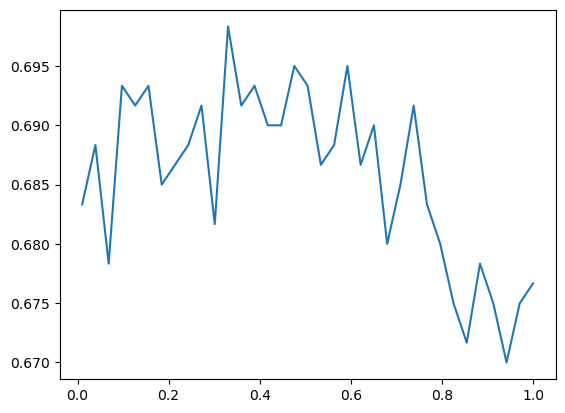

In [28]:
L = np.linspace(0.01,1,35)
scores=[]
for n in L:
    xgb = XGBClassifier(objective='binary:logistic', n_estimators=200, learning_rate=0.01, subsample=n)
    xgb.fit(X_train,y_train)
    y_hat_xgb = xgb.predict(X_test)
    scores.append(accuracy_score(y_test,y_hat_xgb))
plt.plot(list(L),scores)

In [29]:
xgb = XGBClassifier(objective='binary:logistic', n_estimators=200, learning_rate=0.01, subsample=0.5)
xgb.fit(X_train,y_train)
y_hat_xgb = xgb.predict(X_test)
accuracy_score(y_test,y_hat_xgb)

0.6883333333333334